In [15]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
from hexplot import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data and pre-process for analysis

In [16]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]


In [17]:
lineage_sizes = df.groupby(['donor','lineage_id']).size().to_dict()
df['lineage_size'] = df.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)
lineage_sizes = df_clean.groupby(['donor','lineage_id']).size().to_dict()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)


In [18]:
v_mismatch_dict = df[['vdj_sequence', 
                      'v_mismatch']].drop_duplicates(ignore_index=True).set_index('vdj_sequence')
v_mismatch_dict = v_mismatch_dict.to_dict()['v_mismatch']

# First plot hexplot for visualization

TBd6 4009
LN    25683
PB    10386
SP     9047
BM     4009
Name: tissue, dtype: int64
BM    505
SP    372
PB    370
LN    293
Name: permuted_tissue, dtype: int64


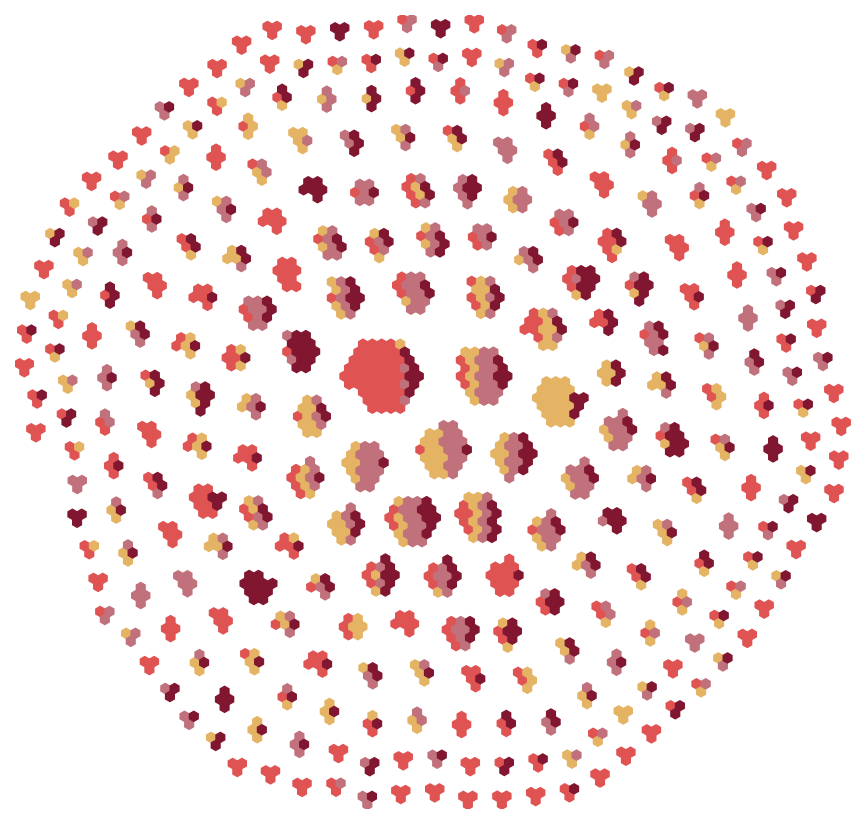

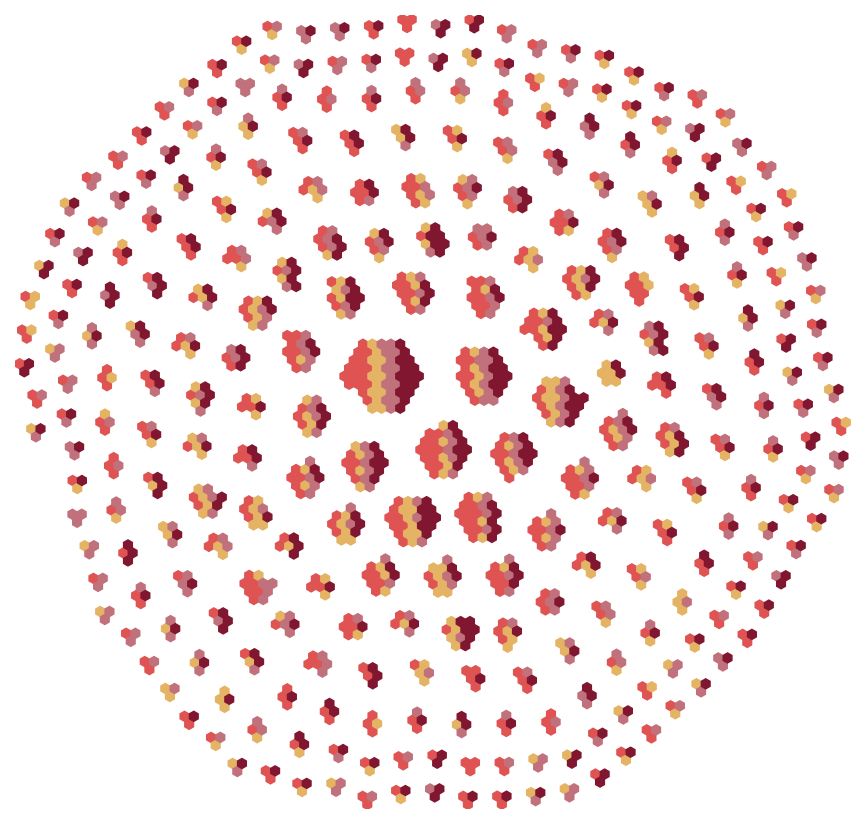

In [19]:
target_donor='TBd6'
ddf = df_clean[(df_clean.donor==target_donor)]
n = ddf.groupby(['tissue']).size().min()
print(target_donor, n)
print(ddf.tissue.value_counts())
ddf = ddf.groupby('tissue').sample(n=n, replace=False).reset_index()
lineage_sizes = ddf.groupby(['donor','lineage_id']).size().to_dict()
ddf['lineage_size'] = ddf.apply(lambda x: lineage_sizes.get((x.donor, x.lineage_id),0),
                                axis=1)
ddf['lineage_size'] = ddf['lineage_size'].astype(str).astype(int)
ddf = ddf[ddf.lineage_size>2]
ddf['permuted_tissue'] = np.random.choice(ddf['tissue'].values,size=ddf.shape[0])
print(ddf.permuted_tissue.value_counts())
fig, ax, new_ddf = plot_hexplot(ddf,
                    group_col='lineage_id',
                    hue='tissue',
                    sort='tissue',
                    cmap=None,
                    palette=tissue_colors)
fig.savefig(f'{FIGURE_OUTDIR}/Figure2/hexplot.pdf', bbox_inches='tight')

fig, ax, new_ddf = plot_hexplot(ddf[ddf['lineage_size']>2],
                    group_col='lineage_id',
                    hue='permuted_tissue',
                    sort='permuted_tissue',
                    cmap=None,
                    palette=tissue_colors)
fig.savefig(f'{FIGURE_OUTDIR}/Figure2/hexplot_permuted.pdf', bbox_inches='tight')

# Calculate distribution of lineage members between tissues

In [20]:
df = df[['vdj_sequence','donor','tissue','lineage_id']].drop_duplicates(ignore_index=True)
df['lineage_uid'] = df['donor'] + "_" + df['lineage_id'].astype(str)
df['donor_tissue'] = df['donor'] + "_" + df['tissue']
n = df.groupby(['donor_tissue']).size().min()
df_downsampled = df.groupby('donor_tissue').sample(n=n, replace=False).reset_index()
permutations = {}
for i in range(100):
    permut = pd.Series('', index=df_downsampled.index)
    for donor in donors:
        donor_subset = df_downsampled.donor==donor
        subset_size = donor_subset.sum()
        permut.loc[donor_subset] = np.random.choice(df_downsampled.loc[donor_subset,'donor_tissue'].values, 
                                                       size = subset_size)
    permutations.update({f'permut_{i}':permut})
permutations = pd.DataFrame(permutations)
df_downsampled = df_downsampled.merge(permutations, left_index=True, right_index=True)
all_samples = df.donor_tissue.unique()


In [21]:
def calculate_tissue_fractions(df, 
                               lineage_col='lineage_uid', 
                               tissue_col='donor_tissue',
                               unique_identifier_col='vdj_sequence'):
    lcol = lineage_col
    tcol = tissue_col
    uid_col = unique_identifier_col
    
    total_counts = df.groupby([lcol])[uid_col].nunique()
    tissue_counts = df.groupby([lcol,tcol])[uid_col].nunique()
    tissue_counts = tissue_counts.reset_index().pivot(index=lcol, columns=tcol, values=uid_col)
    donor_columns = [x for x in tissue_counts.columns if x.startswith("TB")]

    tissue_fractions = tissue_counts[donor_columns].copy()    
    tissue_fractions = (tissue_fractions.T/total_counts).T
    
    return tissue_fractions, total_counts

In [22]:
all_tissue_fractions_data, total_counts = calculate_tissue_fractions(df_downsampled)
all_tissue_fractions_resampled, total_counts_resampled = calculate_tissue_fractions(df_downsampled, tissue_col='permut_0')

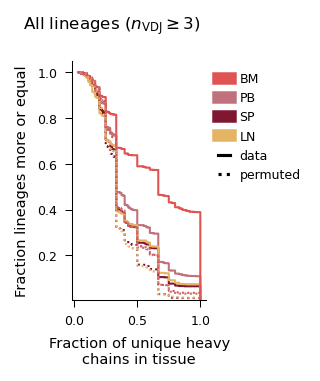

In [23]:


small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)


cats = [#(r"Small lineages ($4\geq  n_\mathrm{VDJ}\geq 3$)", small_lineages),
        #(r"Medium lineages ($9\geq n_\mathrm{VDJ} \geq 5$)", medium_lineages), 
        #(r"Large lineages ($ n_\mathrm{VDJ}\geq 10$)", large_lineages),
        (r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]

for name, subset_lambda in cats:
    fig, axes = plt.subplots(1,1, figsize=(1.5,2.5), sharey=True, sharex=True)
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_data = tissue_fractions_data.melt()
    tissue_fractions_data['tissue'] = tissue_fractions_data['donor_tissue'].str.split("_").map(lambda x: x[1])
    tissue_fractions_data['donor'] = tissue_fractions_data['donor_tissue'].str.split("_").map(lambda x: x[0])
    tissue_fractions_data = tissue_fractions_data[~(tissue_fractions_data.donor=='TBd1')]

    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    tissue_fractions_resampled = tissue_fractions_resampled.melt()
    tissue_fractions_resampled['tissue'] = tissue_fractions_resampled['permut_0'].str.split("_").map(lambda x: x[1])
    tissue_fractions_data['donor'] = tissue_fractions_data['donor_tissue'].str.split("_").map(lambda x: x[0])
    tissue_fractions_data = tissue_fractions_data[~(tissue_fractions_data.donor=='TBd1')]

    fig.suptitle(f"{name}", fontsize=8)
    donors= sorted(list(donor_colors.keys()))
    ax = axes
    sns.ecdfplot(tissue_fractions_data,
                 x='value',
                complementary=True, 
                log_scale=(False, False), 
                ax=ax, 
                palette=tissue_colors, 
                hue='tissue',
                legend=False)
    sns.ecdfplot(tissue_fractions_resampled,
                 x='value',
                complementary=True, 
                log_scale=(False, False), 
                ax=ax, 
                palette=tissue_colors, 
                hue='tissue',
                linestyle='dotted',
                legend=False)
    ax.set_ylim([5*10**-3, 1.05])
    ax.set_xlabel('Fraction of unique heavy\nchains in tissue')
    ax.set_ylabel('Fraction lineages more or equal')
    sns.despine(fig)
    fig.tight_layout()
for tissue in ['BM','PB','SP','LN']:
    axes.plot([],[],label=tissue, lw=6, color=tissue_colors[tissue])
axes.plot([],[], color='k', lw=1.5, label='data')
axes.plot([],[], color='k', lw=1.5, label='permuted', linestyle='dotted')
axes.legend(bbox_to_anchor=(1,1), frameon=False, handlelength=0.95)
fig.savefig(f'{FIGURE_OUTDIR}/unused/distribution_in_lineage_donors2to6.pdf', bbox_inches='tight')

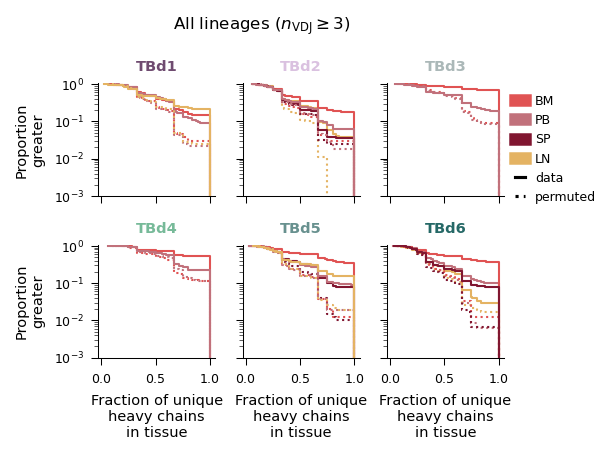

In [24]:


small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)


cats = [#(r"Small lineages ($4\geq  n_\mathrm{VDJ}\geq 3$)", small_lineages),
        #(r"Medium lineages ($9\geq n_\mathrm{VDJ} \geq 5$)", medium_lineages), 
        #(r"Large lineages ($ n_\mathrm{VDJ}\geq 10$)", large_lineages),
        (r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]

for name, subset_lambda in cats:
    fig, axes = plt.subplots(2,3, figsize=(3.5,3), sharey=True, sharex=True)
    axes = axes.flatten()
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    fig.suptitle(f"{name}", fontsize=8)
    donors= sorted(list(donor_colors.keys()))
    for it, donor in enumerate(donors):
        ax = axes[it]
        ax.set_title(donor, weight='bold', color=donor_colors[donor])
        donor_columns = [x for x in all_samples if x.startswith(donor)] 
        for col in donor_columns:
            sns.ecdfplot(tissue_fractions_data[col],
                        # bins=bins,
                        # kde=False,
                        # element='poly',
                        # fill=False,
                        # stat='probability',
                        complementary=True, 
                        log_scale=(False,False), 
                        ax=ax, 
                        color=tissue_colors[col[-2:]])
            sns.ecdfplot(tissue_fractions_resampled[col],
                        # bins=bins,
                        # kde=False,
                        # element='poly',
                        # fill=False,
                        # stat='probability',
                    complementary=True, 
                    log_scale=(False,False), 
                    ax=ax, 
                    color=tissue_colors[col[-2:]],
                    linestyle='dotted')
        ax.set_ylim([10**-3, 1.05])
        ax.set_yscale('log')
        ax.set_xlabel('Fraction of unique\nheavy chains\nin tissue')
        ax.set_ylabel('Proportion\ngreater')
    sns.despine(fig)
    fig.tight_layout()
for tissue in ['BM','PB','SP','LN']:
    axes[2].plot([],[],label=tissue, lw=6, color=tissue_colors[tissue])
axes[2].plot([],[], color='k', lw=1.5, label='data')
axes[2].plot([],[], color='k', lw=1.5, label='permuted', linestyle='dotted')
axes[2].legend(bbox_to_anchor=(1,1), frameon=False, handlelength=0.8)
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure3/EDFigure_tissue_distribution_of_lineages.pdf', bbox_inches='tight')

TBd1
TBd2
TBd3
TBd4
TBd5
TBd6


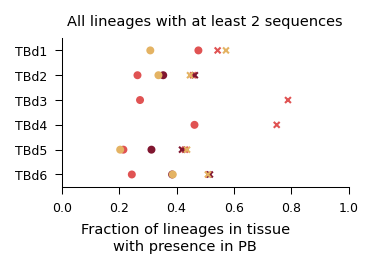

In [25]:

small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
CUTOFF = 1
all_lineages = lambda x: (x > CUTOFF)

cats = [(f"All lineages with at least {CUTOFF+1} sequences", all_lineages)]


for name, subset_lambda in cats:
    fig, axes = plt.subplots(1,1, figsize=(2.5,1.8), sharey=True, sharex=True)
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    axes.set_title(f"{name}",fontsize=7)
    donors= sorted(list(donor_colors.keys()))
    for it, donor in enumerate(donors):
        print(donor)
        ax = axes
        # ax.text(2, 0.9, donor, weight='bold', color=donor_colors[donor])
        donor_columns = [x for x in all_samples if x.startswith(donor)] 
        for full_data_frame, marker, offset in [(tissue_fractions_data,'o', 0.1),
                                   (tissue_fractions_resampled,'x', -0.1)]:

            data_frame = full_data_frame[donor_columns].copy()
            data_frame = data_frame[data_frame.notna().sum(axis=1) > 0]
            
            for tissue in ['PB','BM','SP','LN']:
                data_frame[tissue] = data_frame[[col for col in data_frame.columns if col.endswith(tissue)]].notna().any(axis=1)
            
            fraction = data_frame[data_frame['PB']][['BM','SP','LN']].sum() / data_frame[['BM','SP','LN']].sum()
            xvals = fraction.values
            colors = [tissue_colors[x] for x in fraction.index]
            yvals = [7-int(donor[-1])]*len(xvals)
            ax.scatter(xvals, yvals, marker=marker, color=colors, s=8)

        ax.set_yticks(7-np.arange(1,7), [f'TBd{i}' for i in np.arange(1,7)])
        ax.set_ylim([0.5,6.5])
    sns.despine(fig)
axes.set_xlabel('Fraction of lineages in tissue\nwith presence in PB', fontsize=7, x= 0.43)
# axes.set_xscale('log')
ax.set_ylabel('')
ax.set_xlim([0.0,1])
for tissue in ['BM','PB','SP','LN']:
    axes.plot([],[],label=tissue, lw=5, color=tissue_colors[tissue])
axes.scatter([],[], marker='o',color='k', lw=1.5, label='data')
axes.scatter([],[], marker='x',color='k', lw=1.5, label='permuted')
# axes[5].legend(bbox_to_anchor=(1,1), frameon=False, handlelength=0.8)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/unused/PB_presence_by_donor.pdf', bbox_inches='tight')

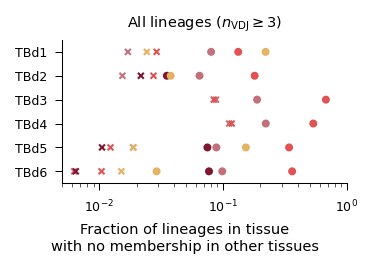

In [26]:

small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)

cats = [(r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]


for name, subset_lambda in cats:
    fig, axes = plt.subplots(1,1, figsize=(2.5,1.8), sharey=True, sharex=True)
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    axes.set_title(f"{name}",fontsize=7)
    donors= sorted(list(donor_colors.keys()))
    for it, donor in enumerate(donors):
        ax = axes
        # ax.text(2, 0.9, donor, weight='bold', color=donor_colors[donor])
        donor_columns = [x for x in all_samples if x.startswith(donor)] 
        for full_data_frame, marker, offset in [(tissue_fractions_data,'o', 0.1),
                                   (tissue_fractions_resampled,'x', -0.1)]:

            data_frame = full_data_frame[donor_columns].copy()
            data_frame = data_frame[data_frame.notna().sum(axis=1) > 0]
            
            single_tissue = (data_frame.notna().sum(axis=1)==1).astype(bool)
            greatest_donor_tissue = data_frame.idxmax(axis=1) 
            smallest_donor_tissue = data_frame.idxmin(axis=1)
            data_frame['greatest_tissue'] = greatest_donor_tissue.map(lambda x: x.split("_")[1])
            data_frame['smallest_tissue'] = smallest_donor_tissue.map(lambda x: x.split("_")[1])
            for tissue in ['PB','BM','SP','LN']:
                data_frame[tissue] = data_frame[[col for col in data_frame.columns if col.endswith(tissue)]].notna().any(axis=1)
            
            single_fraction = data_frame[single_tissue][['PB','BM','SP','LN']].sum() / data_frame[['PB','BM','SP','LN']].sum()
            xvals = single_fraction.values
            colors = [tissue_colors[x] for x in single_fraction.index]
            yvals = [7-int(donor[-1])]*len(xvals)
            ax.scatter(xvals, yvals, marker=marker, color=colors, s=8)

        ax.set_yticks(7-np.arange(1,7), [f'TBd{i}' for i in np.arange(1,7)])
        ax.set_ylim([0.5,6.5])
    sns.despine(fig)
axes.set_xlabel('Fraction of lineages in tissue\nwith no membership in other tissues', fontsize=7, x= 0.43)
axes.set_xscale('log')
ax.set_ylabel('')
ax.set_xlim([0.005,1])
for tissue in ['BM','PB','SP','LN']:
    axes.plot([],[],label=tissue, lw=5, color=tissue_colors[tissue])
axes.scatter([],[], marker='o',color='k', lw=1.5, label='data')
axes.scatter([],[], marker='x',color='k', lw=1.5, label='permuted')
# axes[5].legend(bbox_to_anchor=(1,1), frameon=False, handlelength=0.8)
fig.tight_layout()
fig.savefig(f'{FIGURE_OUTDIR}/unused/private_lineage_fraction.pdf', bbox_inches='tight')

donor_tissue
PB    0.102236
BM    0.353033
SP    0.062368
LN    0.095792
dtype: float64
permut_0
PB    0.031093
BM    0.034274
SP    0.012232
LN    0.014295
dtype: float64


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_91831/933441906.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


permut_0,TBd1_BM,TBd1_LN,TBd1_PB,TBd2_BM,TBd2_LN,TBd2_PB,TBd2_SP,TBd3_BM,TBd3_PB,TBd4_BM,TBd4_PB,TBd5_BM,TBd5_LN,TBd5_PB,TBd5_SP,TBd6_BM,TBd6_LN,TBd6_PB,TBd6_SP
lineage_uid,,,,,,,,,,,,,,,,,,,
TBd1_1004.0,0.333333,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TBd1_1006.0,NaN,0.666667,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TBd1_1022.0,0.400000,0.400000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TBd1_1026.0,0.500000,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TBd1_1028.0,0.666667,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBd6_981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,0.200000,NaN,0.600000
TBd6_983.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,0.571429,0.142857,0.142857
TBd6_987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.166667,0.333333,0.166667


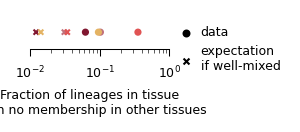

In [27]:

small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)

cats = [(r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]


for name, subset_lambda in cats[-1:]:
    fig, axes = plt.subplots(1,1, figsize=(1.2,0.3), sharey=True, sharex=True)
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    # fig.suptitle(f"{name}",fontsize=7)
    

    for data_frame, marker, offset in [(tissue_fractions_data,'o', 0.1),
                                       (tissue_fractions_resampled,'x', -0.1)]:
        single_tissue = (data_frame.notna().sum(axis=1)==1).astype(bool)

        data_frame = data_frame.copy()#[[c for c in data_frame.columns if not (c.startswith("TBd1"))]].copy()
        data_frame = data_frame[data_frame.notna().sum(axis=1)>0]
        greatest_donor_tissue = data_frame.idxmax(axis=1) 
        smallest_donor_tissue = data_frame.idxmin(axis=1)
        data_frame['greatest_tissue'] = greatest_donor_tissue.map(lambda x: x.split("_")[1])
        data_frame['smallest_tissue'] = smallest_donor_tissue.map(lambda x: x.split("_")[1])
        for tissue in ['PB','BM','SP','LN']:
            data_frame[tissue] = data_frame[[col for col in data_frame.columns if col.endswith(tissue)]].notna().any(axis=1)
        
        single_fraction = data_frame[single_tissue][['PB','BM','SP','LN']].sum() / data_frame[['PB','BM','SP','LN']].sum()

        print(single_fraction)
        xvals = single_fraction.values
        colors = [tissue_colors[x] for x in single_fraction.index]
        yvals = np.ones(len(yvals))#+offset
        axes.scatter(xvals, yvals, marker=marker, color=colors, s=6)

        axes.set_yticks([], [])
        axes.set_ylim([0.5,1.5])
        axes.set_xlim([10**-2,1])
        axes.set_xscale('log')
        axes.set_xlabel('')
    sns.despine(fig, left=True)
axes.set_xlabel('Fraction of lineages in tissue\n with no membership in other tissues', fontsize=6, x= 0.43)

axes.scatter([],[], marker='o',color='k', label='data', s=8)
axes.scatter([],[], marker='x',color='k', label='expectation\nif well-mixed', s=8)

axes.legend(bbox_to_anchor=(1.,1.), frameon=False, handlelength=0.8, loc='upper left')
fig.tight_layout()

fig.savefig(f'{FIGURE_OUTDIR}/Figure2/private_fraction_donors1to6.pdf', bbox_inches='tight')

tissue_fractions_resampled

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_91831/1949198543.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[tissue] = data_frame[[col for col in data_frame.columns if col.endswith(tissue)]].notna().any(axis=1)
/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_91831/1949198543.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[tissue] = data_frame[[col for col in data_frame.columns if col.endswith(tissue)]].notna().any(axis=1)
/var/folders/dz/swf8xvz50dv7

permut_0,TBd1_BM,TBd1_LN,TBd1_PB,TBd2_BM,TBd2_LN,TBd2_PB,TBd2_SP,TBd3_BM,TBd3_PB,TBd4_BM,...,TBd5_PB,TBd5_SP,TBd6_BM,TBd6_LN,TBd6_PB,TBd6_SP,PB,BM,SP,LN
lineage_uid,,,,,,,,,,,,,,,,,,,,,
TBd1_1004.0,0.333333,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
TBd1_1006.0,NaN,0.666667,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,True
TBd1_1022.0,0.400000,0.400000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True
TBd1_1026.0,0.500000,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
TBd1_1028.0,0.666667,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBd6_981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.400000,0.200000,NaN,0.600000,False,True,True,True
TBd6_983.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.142857,0.571429,0.142857,0.142857,True,True,True,True
TBd6_987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,0.166667,0.333333,0.166667,True,True,True,True


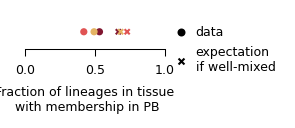

In [28]:

small_lineages = lambda x: (x < 5) & (x > 2)
medium_lineages = lambda x: (x < 10) & (x > 4)
large_lineages = lambda x: (x > 9)
all_lineages = lambda x: (x > 2)

cats = [(r"All lineages ($ n_\mathrm{VDJ}\geq 3$)", all_lineages)]


for name, subset_lambda in cats[-1:]:
    fig, axes = plt.subplots(1,1, figsize=(1.2,0.3), sharey=True, sharex=True)
    bins=np.linspace(0,1,20)
    tissue_fractions_data=all_tissue_fractions_data[subset_lambda(total_counts)]
    tissue_fractions_resampled = all_tissue_fractions_resampled[subset_lambda(total_counts_resampled)]
    # fig.suptitle(f"{name}",fontsize=7)
    

    for data_frame, marker, offset in [(tissue_fractions_data,'o', 0.1),
                                    (tissue_fractions_resampled,'x', -0.1)]:
        
        for tissue in ['PB','BM','SP','LN']:
            data_frame[tissue] = data_frame[[col for col in data_frame.columns if col.endswith(tissue)]].notna().any(axis=1)
        in_blood = data_frame['PB']
        blood_fraction = data_frame[in_blood][['BM','SP','LN']].sum() / data_frame[['BM','SP','LN']].sum()

        xvals = blood_fraction.values
        colors = [tissue_colors[x] for x in blood_fraction.index]
        yvals = np.ones(len(xvals))#+offset
        axes.scatter(xvals, yvals, marker=marker, color=colors, s=6)

        axes.set_yticks([], [])
        axes.set_ylim([0.5,1.5])
        axes.set_xlim([0,1])
        # axes.set_xscale('log')
        axes.set_xlabel('')
    sns.despine(fig, left=True)
axes.set_xlabel('Fraction of lineages in tissue\n with membership in PB', fontsize=6, x= 0.43)

axes.scatter([],[], marker='o',color='k', label='data', s=8)
axes.scatter([],[], marker='x',color='k', label='expectation\nif well-mixed', s=8)

axes.legend(bbox_to_anchor=(1.,1.), frameon=False, handlelength=0.8, loc='upper left')
fig.tight_layout()

fig.savefig(f'{FIGURE_OUTDIR}/unused/PB_presence_donors1to6.pdf', bbox_inches='tight')

tissue_fractions_resampled